In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
import torch
from torch.optim.adamw import AdamW
from torch.optim.adam import Adam
from tqdm import tqdm

sys.path.append(os.path.expanduser('..'))

from environments.sac_tracking_env import Environment
from plot import tracking_interface
from data_prep import load, generate, draw
from models import ResNet3D, ResidualBlock3D, ConvNet
from memory.buffer import PrioritizedReplayBuffer
from solvers import sac

DEVICE = 'cuda:0'
dtype = torch.float32

In [73]:
parameters_file = '/home/brysongray/neurotrack/configs/simulate_neurons_de-novo.json'
with open(parameters_file, 'r') as f:
    parameters = json.load(f)

labels_dir = parameters["labels_dir"] if "labels_dir" in parameters else None
out = parameters["out"]
if not os.path.exists(out):
    os.makedirs(out)
width = parameters["width"]
random_contrast = parameters["random_contrast"]
dropout = parameters["dropout"]
random_brightness = parameters["random_brightness"]
noise = parameters["noise"]
binary = parameters["binary"]
seed = parameters["seed"]
rng = np.random.default_rng(seed)
adjust=False

if labels_dir is not None: # Load existing neuron trees as swc files
    adjust=True
    print(f"Loading existing neuron trees as swc files...\n"
            f"    labels_dir: {labels_dir}")
    files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], "*.swc"))]
    swc_lists = []
    fnames = []
    for f in files:
        swc_lists.append(load.swc(f))
        fnames.append(f.split('/')[-1].split('.')[0])
    print("done")

else: # Generate simulated neuron trees
    # count = parameters["count"]
    count = 1
    size = (parameters["size"],)*3
    length = parameters["length"]
    stepsize = parameters["stepsize"]
    uniform_len = parameters["uniform_len"]
    kappa = parameters["kappa"]
    random_start = parameters["random_start"]
    branches = parameters["branches"]

    print(f"Generating simulated neuron trees...\n"
            f"    size: {size}\n"
            f"    length: {length}\n"
            f"    step size: {stepsize}\n"
            f"    uniform_len: {uniform_len}\n"
            f"    kappa: {kappa}\n"
            f"    random_start: {random_start}\n"
            f"    branches: {branches}")

    swc_lists = []
    fnames = []
    for i in tqdm(range(count)):
        swc_list = generate.make_swc_list(size,
                                length=length,
                                step_size=stepsize,
                                kappa=kappa,
                                uniform_len=uniform_len,
                                random_start=random_start,
                                rng=rng,
                                num_branches=branches) # make simulated neuron paths.
        swc_lists.append(swc_list)

Generating simulated neuron trees...
    size: (101, 101, 101)
    length: 20
    step size: 3.0
    uniform_len: 0
    kappa: 15.0
    random_start: 1
    branches: 2


100%|██████████| 1/1 [00:00<00:00, 165.89it/s]


In [74]:
color = np.array([1.0, 1.0, 1.0])
background = np.array([0., 0., 0.])
swc_data = draw.neuron_from_swc(swc_lists[0],
                                width=width,
                                noise=noise,
                                adjust=adjust,
                                neuron_color=color,
                                background_color=background,
                                random_brightness=random_brightness,
                                dropout=dropout,
                                binary=binary)

In [87]:
# image directory
# img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/neuromorpho/neuromorpho_with_artifacts/"
# img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/de-novo/3d_with_artifacts_b-0/"
img_dir = "/home/brysongray/data/neurotrack_data/simulated_neurons/de-novo/curves_no_artifacts_b-2/"

# instantiate environment

env = Environment(img_dir,
                radius=17,
                step_size=2.0,
                step_width=3.0,
                alpha=1.0,
                beta=0.2,
                repeat_starts=False)

In [6]:
plt.close('all')

reward: tensor([-9.8915])
terminated: False


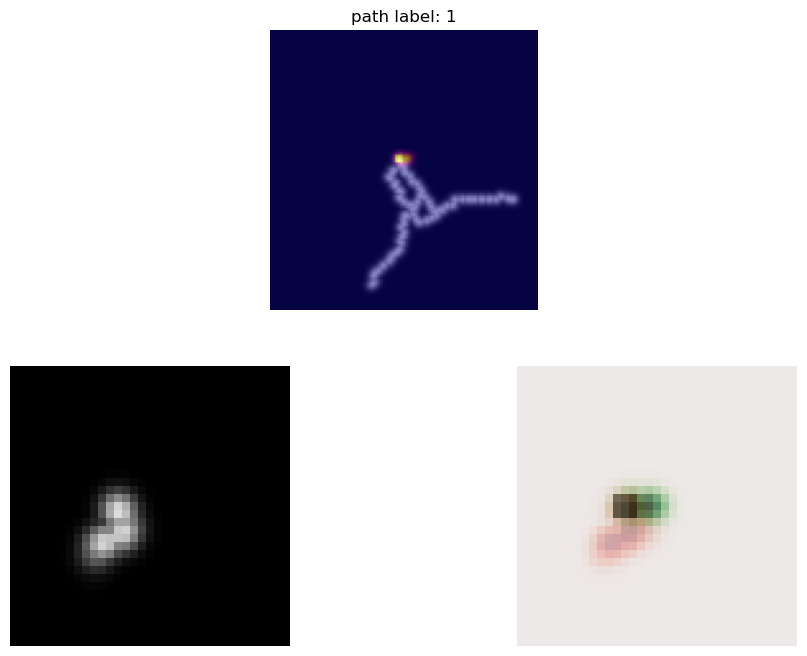

In [56]:
tracking_interface.manual_step(env)

In [8]:
env.img_files[env.img_idx]

'/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts/150304_2_3_d'

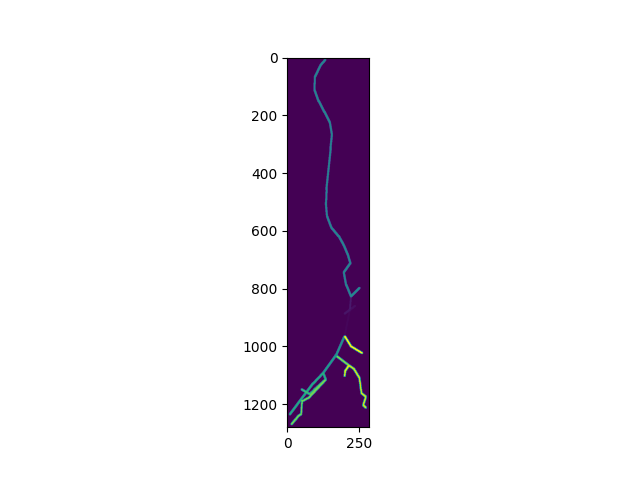

In [6]:
labels = env.section_labels.data[0]

plt.imshow(labels.amax(0))

In [13]:
# config = '/home/brysongray/neurotrack/configs/train_sac_neuromorpho.json'
config = '/home/brysongray/neurotrack/configs/train_sac_simulated.json'
with open(config) as f:
    params = json.load(f)
    
img_path = params["img_path"]
outdir = params["outdir"]
name = params["name"]
step_size = params["step_size"] if "step_size" in params else 1.0
step_width = params["step_width"] if "step_width" in params else 1.0
batch_size = params["batchsize"] if "batchsize" in params else 256
tau = params["tau"] if "tau" in params else 0.005
gamma = params["gamma"] if "gamma" in params else 0.99
lr = params["lr"] if "lr" in params else 0.001
alpha = params["alpha"] if "alpha" in params else 1.0
beta = params["beta"] if "beta" in params else 1e-3
friction = params["friction"] if "friction" in params else 1e-4
n_episodes = params["n_episodes"] if "n_episodes" in params else 100
init_temperature = params["init_temperature"] if "init_temperature" in params else 0.005
target_entropy = params["target_entropy"] if "target_entropy" in params else 0.0
branching = params["branching"] if "branching" in params else True
section_masking = params["section_masking"] if "section_masking" in params else False
patch_radius = 17


env = Environment(img_path,
                radius=patch_radius,
                step_size=step_size,
                step_width=step_width,
                max_len=1000,
                alpha=alpha,
                beta=beta,
                friction=friction,
                branching=branching,
                section_masking=section_masking)

in_channels = 4
input_size = 2*patch_radius+1
init_temperature = 0.005
actor = ConvNet(chin=in_channels, chout=5)
actor = actor.to(device=DEVICE,dtype=dtype)

Q1 = ConvNet(chin=in_channels+4,chout=1)
Q1 = Q1.to(device=DEVICE,dtype=dtype)
Q2 = ConvNet(chin=in_channels+4,chout=1)
Q2 = Q2.to(device=DEVICE,dtype=dtype)
Q1_target = ConvNet(chin=8,chout=1)
Q1_target = Q1_target.to(device=DEVICE,dtype=dtype)
Q2_target = ConvNet(chin=8,chout=1)
Q2_target = Q2_target.to(device=DEVICE,dtype=dtype)

if "sac_weights" in params:
    sac_path = params["sac_weights"]
    state_dicts = torch.load(sac_path)#, weights_only=True)
    actor.load_state_dict(state_dicts["policy_state_dict"])
    Q1.load_state_dict(state_dicts["Q1_state_dict"])
    Q2.load_state_dict(state_dicts["Q2_state_dict"])

Q1_target.load_state_dict(Q1.state_dict())
Q2_target.load_state_dict(Q2.state_dict())

log_alpha = torch.log(torch.tensor(init_temperature).to(DEVICE))
log_alpha.requires_grad = True
Q1_optimizer = AdamW(Q1.parameters(), lr=lr)
Q2_optimizer = AdamW(Q2.parameters(), lr=lr)
actor_optimizer = AdamW(actor.parameters(), lr=lr)
log_alpha_optimizer = Adam([log_alpha], lr=lr)

memory = PrioritizedReplayBuffer(100000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(4,), alpha=0.8)

TP: 14, FP: 34, FN: 0, TN: 37


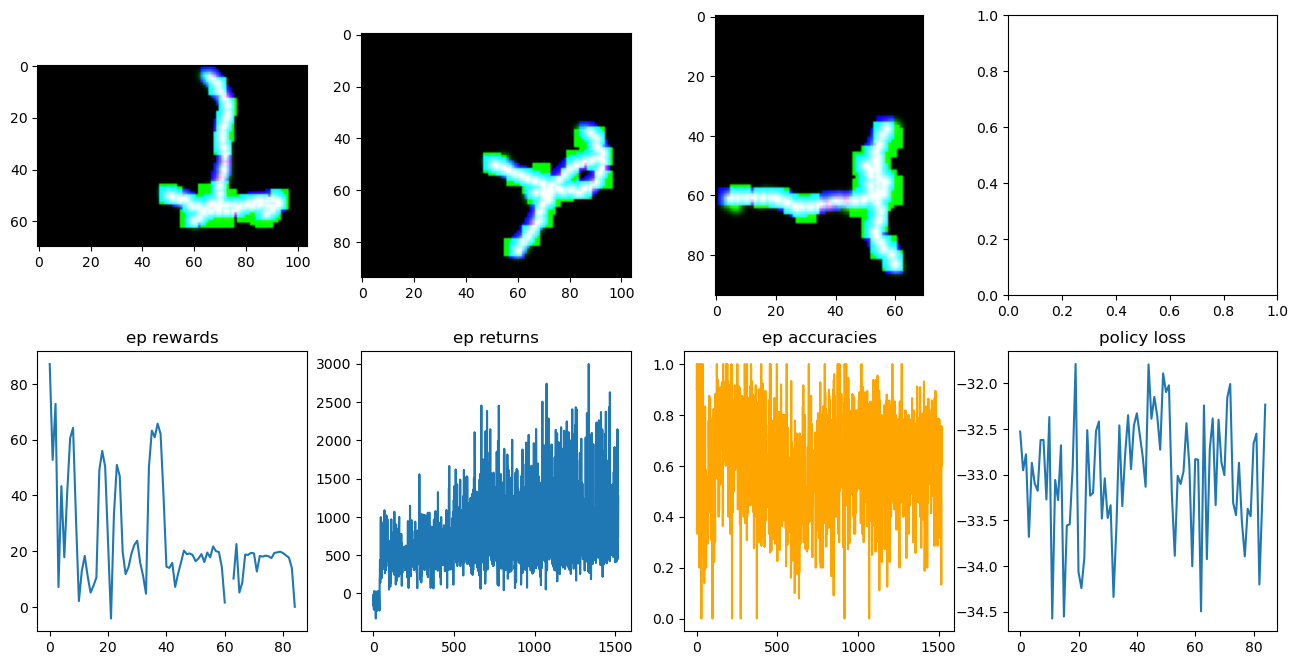

 76%|███████▌  | 1520/2000 [2:37:36<1:28:31, 11.06s/it]

num branches: 48


/home/brysongray/neurotrack/notebooks/../solvers/sac.py:51: UserWarning: NaN detected in output tensor in sample_from_output
  warnings.warn("NaN detected in output tensor in sample_from_output")
 76%|███████▌  | 1520/2000 [2:37:39<49:47,  6.22s/it]  


AssertionError: 

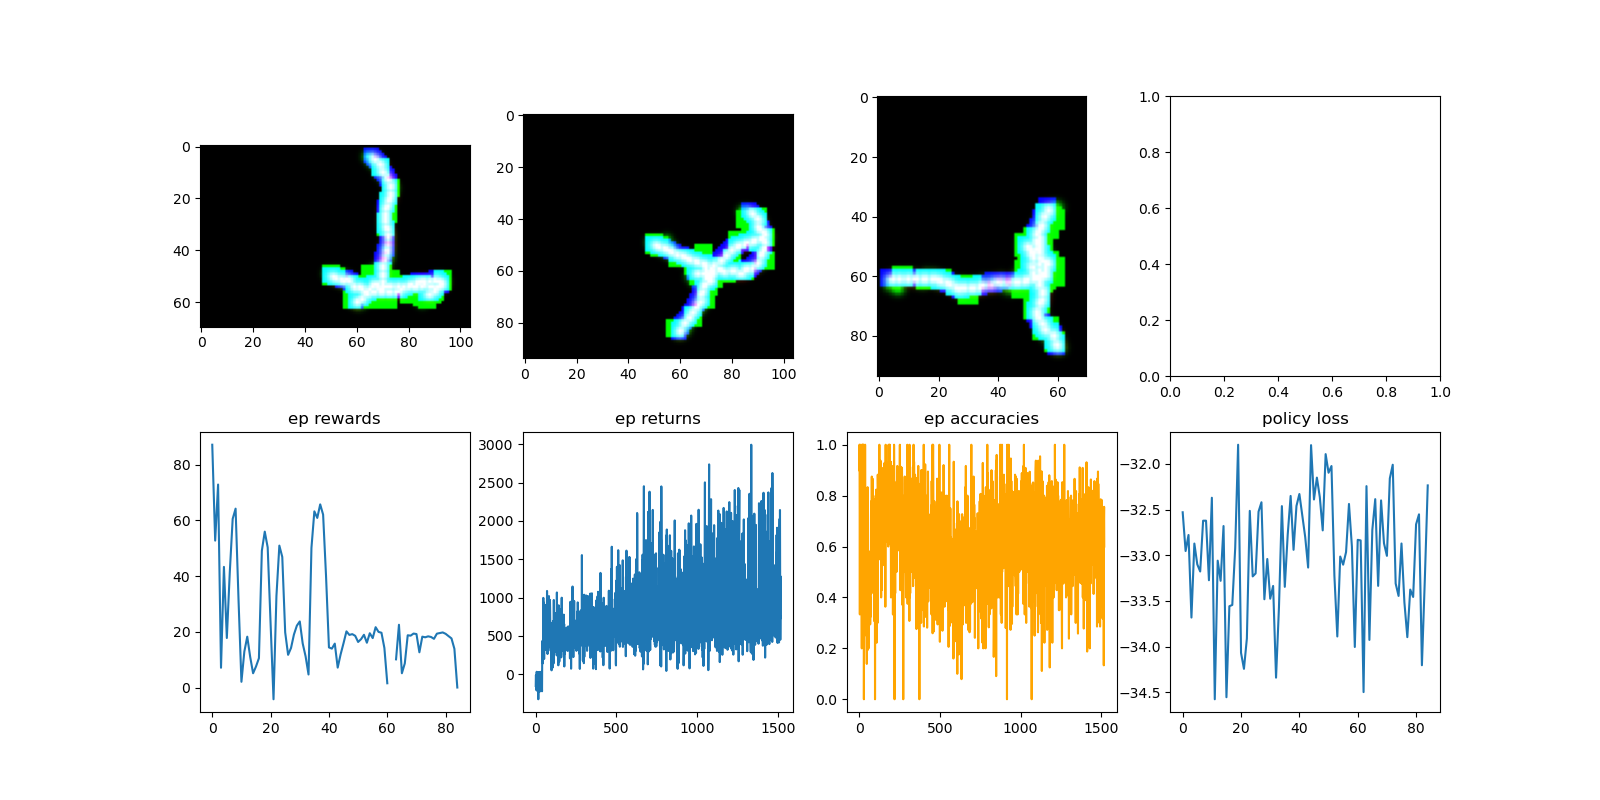

In [14]:
sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=True, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)

In [7]:
import cProfile

with cProfile.Profile() as pr:
    sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=False, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)
    
    # Sort stats by cumulative time
    pr.print_stats(sort='tottime')

100%|██████████| 4/4 [00:43<00:00, 10.87s/it]

         1258878 function calls (1108464 primitive calls) in 43.487 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    22591   30.927    0.001   30.927    0.001 {method 'read' of '_io.BufferedReader' objects}
18900/11384    8.471    0.000    8.356    0.001 {built-in method zlib.decompress}
18900/12102    0.796    0.000    0.742    0.000 tifffile.py:9445(func)
      108    0.590    0.005    0.590    0.005 {built-in method torch.cat}
     3600    0.357    0.000    0.357    0.000 {built-in method torch.conv3d}
22110/8733    0.257    0.000  125.762    0.014 tifffile.py:15056(read_segments)
        8    0.177    0.022   42.465    5.308 sac_tracking_env.py:447(reset)
       41    0.153    0.004    0.242    0.006 {method 'poll' of 'select.epoll' objects}
        4    0.116    0.029   41.688   10.422 sac_tracking_env.py:215(__load_data)
      125    0.100    0.001    0.100    0.001 {built-in method torch.zeros}
     3600    0.094 

In [5]:
import cProfile

with cProfile.Profile() as pr:
    sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=False, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)
    
    # Sort stats by cumulative time
    pr.print_stats(sort='tottime')

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

         765134 function calls (749240 primitive calls) in 34.694 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14659   21.701    0.001   21.701    0.001 {method 'acquire' of '_thread.lock' objects}
       85    5.485    0.065    8.365    0.098 sac_tracking_env.py:319(step)
      385    1.104    0.003    1.904    0.005 image.py:162(crop)
       85    0.964    0.011    0.966    0.011 buffer.py:152(push)
       81    0.881    0.011    0.881    0.011 {built-in method cat}
      166    0.784    0.005    0.784    0.005 {built-in method ones}
     2628    0.594    0.000    0.594    0.000 {built-in method conv3d}
      304    0.470    0.002    0.470    0.002 {method 'clone' of 'torch._C._TensorBase' objects}
        8    0.469    0.059   24.230    3.029 sac_tracking_env.py:447(reset)
       93    0.281    0.003    0.281    0.003 {built-in method zeros}
        4    0.235    0.059   22.630    5.657 sac_tracking_env.py:215(__l

In [9]:
len(env.finished_paths)

33

In [10]:
print([len(f) for f in env.finished_paths])

[4, 4, 6, 10, 14, 3, 31, 16, 27, 16, 22, 20, 27, 35, 36, 67, 28, 21, 18, 41, 18, 14, 47, 71, 82, 36, 102, 88, 70, 20, 95, 21, 93]
